<a href="https://colab.research.google.com/github/Satorumi/Machine-Learning/blob/main/TimeSeries_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis

### 1. Downloading dataset

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Tiingo.txt to Tiingo.txt
User uploaded file "Tiingo.txt" with length 62 bytes


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d vignesh9147/reliance-nse-stock-data

#### Context


> The data is of National Stock Exchange of India's stock listings for each trading day of 2016 and 2017.
  The data is compiled to felicitate Machine Learning, without bothering much about Stock APIs.



In [ ]:
import pandas as pd

In [ ]:
nse = pd.read_csv('/content/reliance-nse-stock-data.zip')

In [ ]:
nse.head()

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
0,RELIANCE,EQ,1-Jan-16,1014.60,1009.80,1018.9,1008.20,1013.6,1015.35,1015.52,1238135,1.257353e+09,30701,529539,42.77
1,RELIANCE,EQ,4-Jan-16,1015.35,1005.00,1013.8,986.70,993.2,995.30,998.91,6896571,6.889070e+09,66235,4974602,72.13
2,RELIANCE,EQ,5-Jan-16,995.30,1000.30,1010.0,997.00,1005.0,1005.15,1003.41,3416459,3.428125e+09,59935,1987804,58.18
3,RELIANCE,EQ,6-Jan-16,1005.15,1007.60,1038.4,1000.40,1029.1,1032.20,1028.15,6116855,6.289073e+09,160947,2912662,47.62
4,RELIANCE,EQ,7-Jan-16,1032.20,1021.05,1028.0,1008.05,1018.9,1013.25,1016.73,4512219,4.587700e+09,105075,2474491,54.84


#### Data visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
sns.set_palette('vlag')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['figure.max_open_warning'] = 1

In [ ]:
nse.Date = pd.to_datetime(nse.Date)

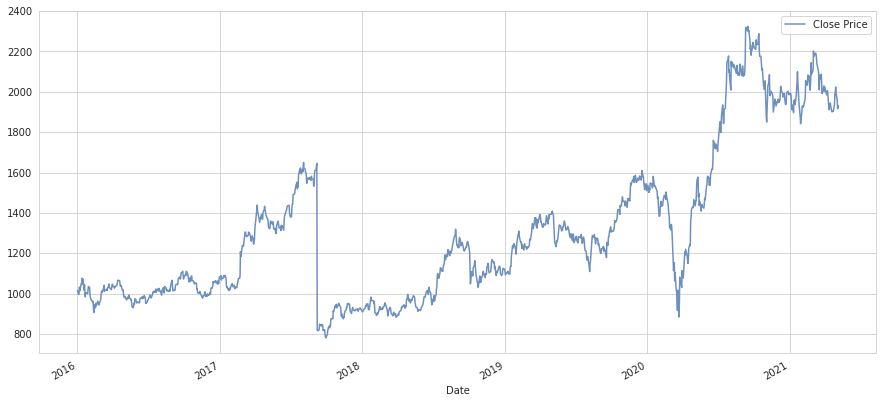

In [ ]:
nse.plot(x = "Date", y = "Close Price")

### 2. Data preprocessing

In [ ]:
! pip install statsmodels --upgrade --quiet

In [ ]:
import statsmodels
statsmodels.__version__

'0.12.2'

#### 2.1 Check for datatype and missing value

In [ ]:
nse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Symbol                  1324 non-null   object        
 1   Series                  1324 non-null   object        
 2   Date                    1324 non-null   datetime64[ns]
 3   Prev Close              1324 non-null   float64       
 4   Open Price              1324 non-null   float64       
 5   High Price              1324 non-null   float64       
 6   Low Price               1324 non-null   float64       
 7   Last Price              1324 non-null   float64       
 8   Close Price             1324 non-null   float64       
 9   Average Price           1324 non-null   float64       
 10  Total Traded Quantity   1324 non-null   int64         
 11  Turnover                1324 non-null   float64       
 12  No. of Trades           1324 non-null   int64   

In [ ]:
target_col = 'Close Price'
price_col = ['Last Price', 'Low Price', 'Open Price', 'Prev Close', 'Average Price', 'High Price', target_col]
numerical_cols = nse.select_dtypes(np.number).columns.drop(price_col)
categorical_cols = nse.select_dtypes('object').columns
datetime_cols = nse.select_dtypes('datetime').columns

#### 2.2 Smoothing data / Resampling



Resampling can provide additional information on the data. Two types of resampling:

- **Upsampling:** increase frequency of sample (e.g. days to hour
- **Downsampling:** 
decrease frequency of sample (e.g. week to month)

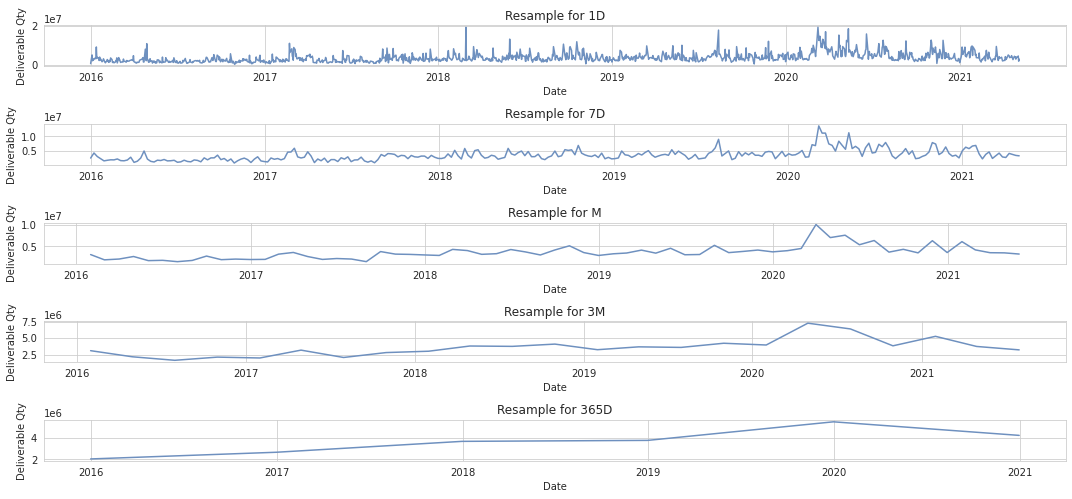

In [ ]:
col = 'Deliverable Qty'
resamplings = ['1D', '7D', 'M', '3M', '365D']
for i, r in enumerate(resamplings):
  resampled = nse.resample(r, on='Date').mean().reset_index(drop = False)
  plt.subplot(5, 1, i+1)
  sns.lineplot(data = resampled, x = 'Date', y = col)
  plt.title(f'Resample for {r}')

plt.tight_layout()

#### 2.3 Stationarity



> Stationarity describes that the time-series has

- constant mean and mean is not time-dependent
- constant variance and variance is not time-dependent
- constant covariance and covariance is not time-dependent




> **Approaches**:


1. visually: plot time series and check for trends or seasonality
2. basic statistics: split time series and compare the mean and variance of each partition
3. statistical test: Augmented Dickey Fuller test




2.3.1 Visually

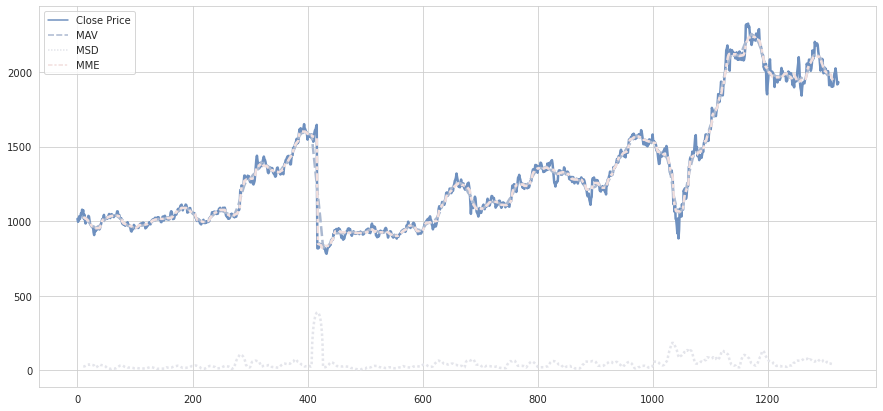

In [ ]:
rolling_window = 20
col = ['Close Price']
rolling_df = nse[col].assign(
    MAV = nse['Close Price'].rolling(rolling_window, center = True).mean(),
    MSD = nse['Close Price'].rolling(rolling_window, center = True).std(),
    MME = nse['Close Price'].rolling(rolling_window, center = True).median()
)
sns.lineplot(data=rolling_df, linewidth=2.5)
# sns.lineplot(x = nse.Date, y = MAV)
# sns.lineplot(x = nse.Date, y = nse['Close Price'])
# sns.lineplot(x = nse.Date, y = MSD)
# plt.legend(['Moving Avg', 'Moving Std'])
# plt.title('Stationarity', fontsize=17)
# plt.figtext(f'Rolling Window: {rolling_window}')



> ***visual check***: feature don't have constant mean and std



2.3.2 Augmented Dickey-Fuller (ADF)

**Unit root Test**

*Unit root:* a charateristic makes time series non-stationart

ADF test belong the unit root test.


> The presence of a unit root means the time series is non-stationary.



**Augmented Dickey-Fuller (ADF)** test is a type of statistical test called a unit root test

- **Null Hypothesis (H0):** Time series has a unit root. (Time series is not stationary)

- **Alternate Hypothesis (H1):** Time series has no unit root (Time series is stationary)

To reject null hypothesis:
  - p-value < significance level (default: 0.05)
  - ADF statistic < critical value

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
adfuller(nse['Close Price'].values)

(-1.3517501576682647,
 0.6051768942409834,
 0,
 1323,
 {'1%': -3.4353024060562674,
  '10%': -2.5679344166325304,
  '5%': -2.863727092349239},
 12912.10628178982)

In [ ]:
def visualize_adfuller_results(series, ylab):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=nse.Date, y=series, color=linecolor)
    plt.title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    plt.ylabel(ylab, fontsize = 14)

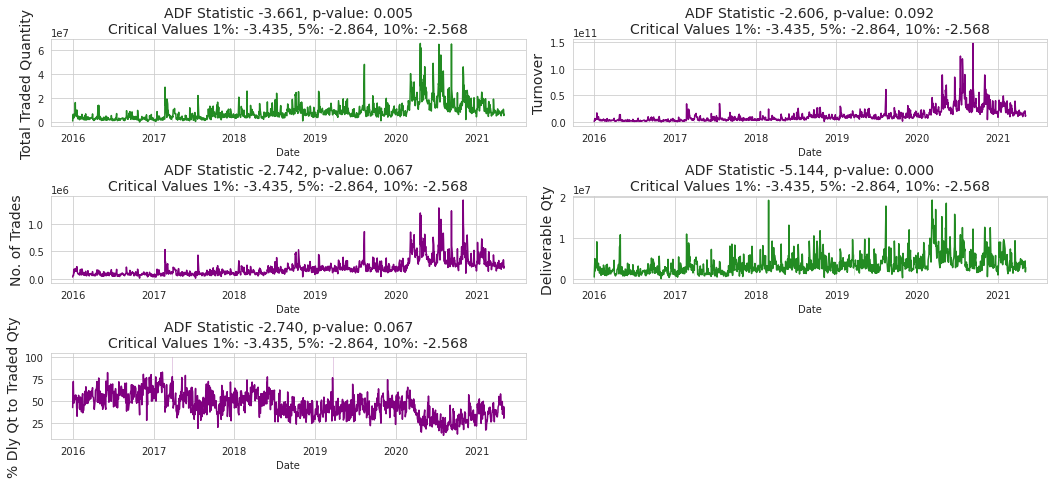

In [ ]:
for i, col in enumerate(numerical_cols):
  plt.subplot(3, 2, i+1)
  visualize_adfuller_results(nse[col].values, col)
plt.tight_layout(pad=2, w_pad=.6, h_pad=.6)

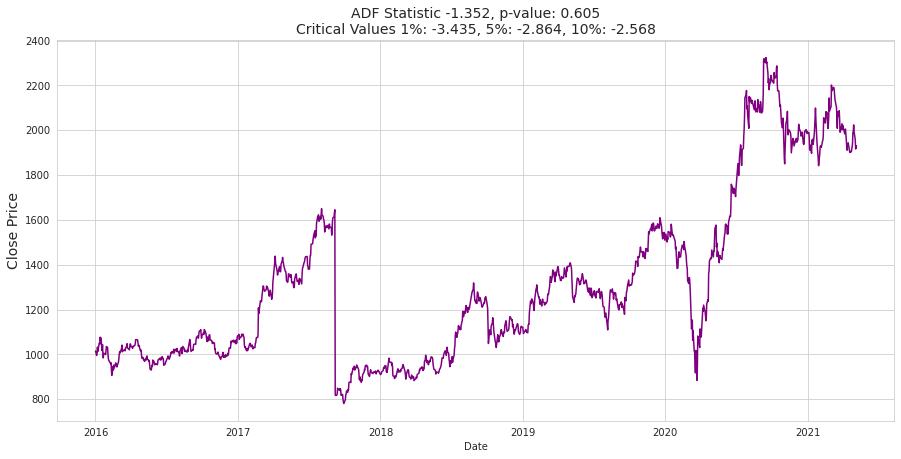

In [ ]:
visualize_adfuller_results(nse['Close Price'], 'Close Price')



> We checked that:
  - Not all features are stationarized

In order to use model such as ARIMA, stationarity of features are required. Therefore, data must be transformed. Two common transformation for time series:
 - **Transformation:** e.g. log or square root to stabilize non-constant variance

- **Differencing:** subtracts the current value from the previous



#### 2.4 Transforming and Differencing

2.4.1 Transforming

In [ ]:
import numpy as np

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


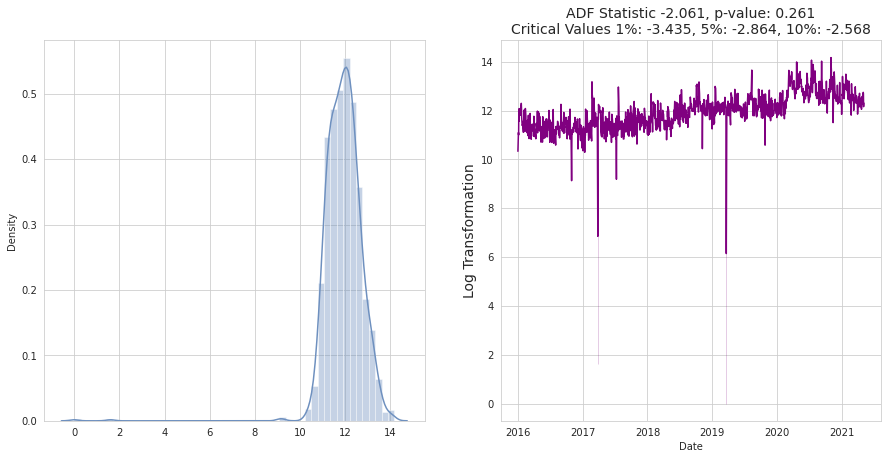

In [ ]:
log_feature = np.log(np.abs(nse['No. of Trades']))
f, ax = plt.subplots(1, 2)
sns.distplot(x = log_feature, ax=ax[0])
ax[1] = visualize_adfuller_results(log_feature, 'Log Transformation')

2.4.2 Differencing

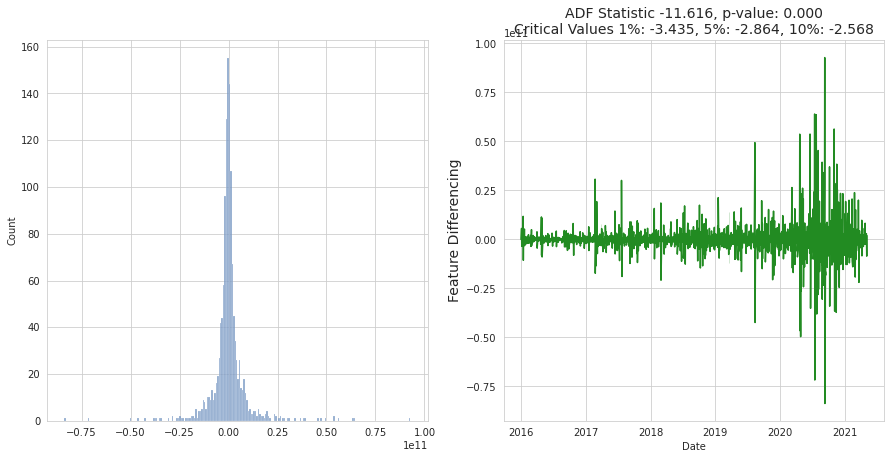

In [ ]:
feature_diff = np.append([0], np.diff(nse.Turnover))
f, ax = plt.subplots(1, 2)
sns.histplot(feature_diff, ax = ax[0])
ax[1] = visualize_adfuller_results(feature_diff, 'Feature Differencing')

### 3. Feature engineering

#### 3.1 Adding useful features

In [ ]:
nse = nse.assign(year = nse.Date.dt.year,
                month = nse.Date.dt.month,
                day = nse.Date.dt.day,
                quarter = nse.Date.dt.quarter,
                day_of_year = nse.Date.dt.dayofyear,
                day_of_week = nse.Date.dt.dayofweek,
                week_of_year = nse.Date.dt.weekofyear)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


In [ ]:
nse.head(3)

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty,year,month,day,quarter,day_of_year,day_of_week,week_of_year
0,RELIANCE,EQ,2016-01-01,1014.60,1009.8,1018.9,1008.2,1013.6,1015.35,1015.52,1238135,1.257353e+09,30701,529539,42.77,2016,1,1,1,1,4,53
1,RELIANCE,EQ,2016-01-04,1015.35,1005.0,1013.8,986.7,993.2,995.30,998.91,6896571,6.889070e+09,66235,4974602,72.13,2016,1,4,1,4,0,1
2,RELIANCE,EQ,2016-01-05,995.30,1000.3,1010.0,997.0,1005.0,1005.15,1003.41,3416459,3.428125e+09,59935,1987804,58.18,2016,1,5,1,5,1,1


#### 3.2 Encoding Cyclical Feature

Encoding Cyclical feature is important and useful, especially for Deep Learning Model. It might not be handy for algorithms such as tree-based approach

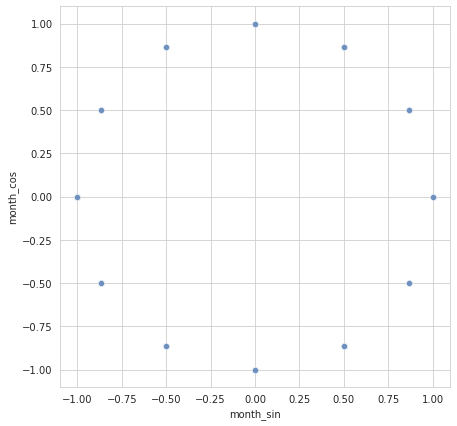

In [ ]:
month_in_year = 12
nse['month_sin'] = np.sin(2 * np.pi * nse.month / month_in_year)
nse['month_cos'] = np.cos(2 * np.pi * nse.month / month_in_year)

plt.figure(figsize = (7, 7))
sns.scatterplot(x = nse.month_sin, y = nse.month_cos)

####3.3 Time Series Decomposition

- **Systematic:** Components of the time series that have consistency or recurrence and can be described and modeled.

    1. **Level:** The average value in the series.
    2.   **Trend:** The increasing or decreasing value in the series
    3. **Seasonality:** The repeating short-term cycle in the series


- **Non-Systematic:** Components of the time series that cannot be directly modeled
 
  1. **Noise**: The random variation in the series


> Every time series has level and noise. Seasonality and Trend are optional





Model type:
- Additive Model: linear, changes over time are consistently made by the same amount
- Multiplicative Model: non-linear,  Changes increase or decrease over time

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
obs_period = 52

for col in numerical_cols:
    decomp = seasonal_decompose(nse[col], model='additive', extrapolate_trend='freq', period = obs_period)
    nse[f"{col} Trend"] = decomp.trend
    nse[f"{col} Seasonal"] = decomp.seasonal

Text(0.5, 0.98, 'Decomposition of Feature')

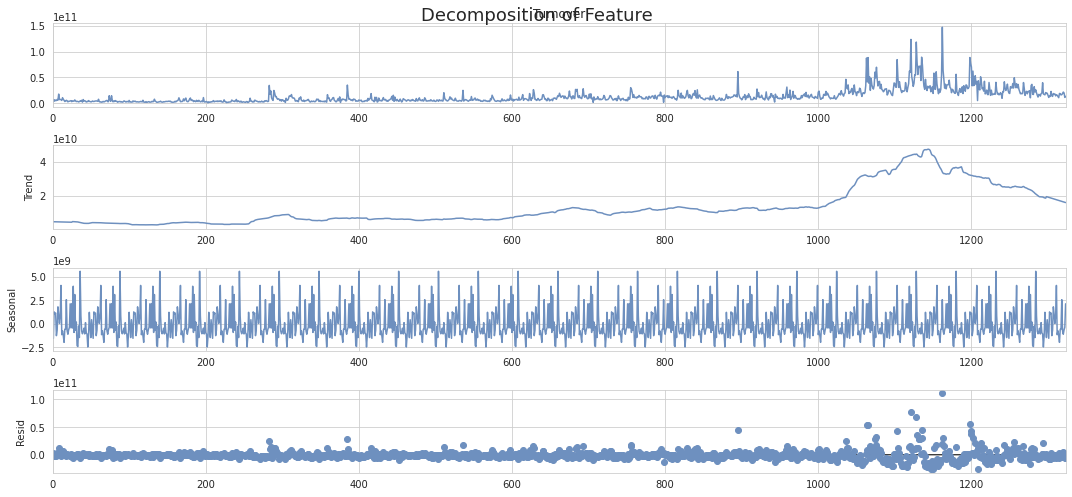

In [ ]:
rand = np.random.randint(1, 6)

decomp = seasonal_decompose(nse[numerical_cols[rand]], model='additive', extrapolate_trend='freq', period = obs_period)
decomp.plot();
plt.suptitle('Decomposition of Feature', fontsize = 18)

  #### 3.4 Lag

using `shift()` to compare the correlation with backward shift and forward shift

In [ ]:
weeks_in_month = 4
shifted = pd.DataFrame()

for col in numerical_cols:
  shifted[f'{col} Shift B1M'] = nse[f'{col} Seasonal'].shift(-1 * weeks_in_month)
  shifted[f'{col} Shift 1M'] = nse[f'{col} Seasonal'].shift(1 * weeks_in_month)

In [ ]:
shifted.head()

,Total Traded Quantity Shift B1M,Total Traded Quantity Shift 1M,Turnover Shift B1M,Turnover Shift 1M,No. of Trades Shift B1M,No. of Trades Shift 1M,Deliverable Qty Shift B1M,Deliverable Qty Shift 1M,% Dly Qt to Traded Qty Shift B1M,% Dly Qt to Traded Qty Shift 1M
0,1.203617e+06,NaN,1.159802e+09,NaN,33452.597706,NaN,461618.171597,NaN,0.449713,NaN
1,-3.255896e+05,NaN,-1.250095e+09,NaN,8225.197124,NaN,-11154.813248,NaN,-0.875740,NaN
2,-3.024986e+05,NaN,-6.626867e+08,NaN,1588.173022,NaN,-103900.772944,NaN,0.148870,NaN
3,1.625428e+06,NaN,1.806358e+09,NaN,34998.143372,NaN,710198.812478,NaN,0.475311,NaN
4,9.331471e+05,-86749.17808,1.005035e+09,-5.760848e+08,32200.733175,-6323.594717,509921.880888,169203.835086,-0.539817,1.114856


### 4. EDA -  Explore Data Analysis

#### 4.1 Features & Target

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


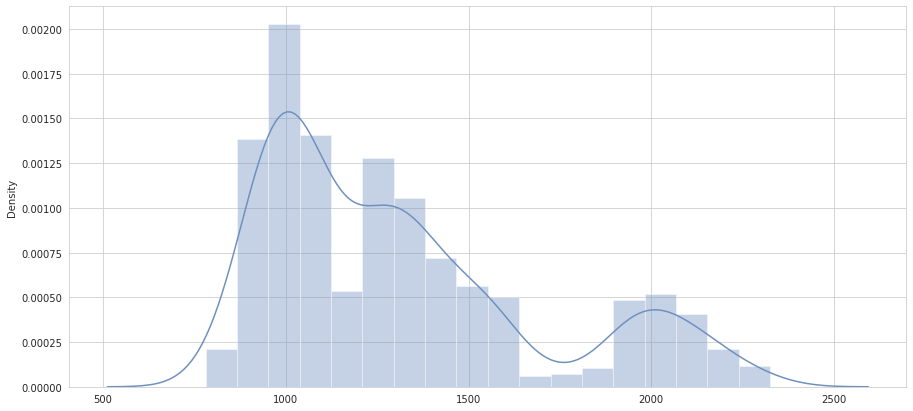

In [ ]:
sns.distplot(x = nse['Close Price'])

Close Price monthly every year


In [ ]:
def hboxplot(x, y, **kwargs):
  sns.boxplot(x=x, y=y, orient='h', palette='vlag', width=.6, **kwargs)
  plt.xticks(rotation=90)

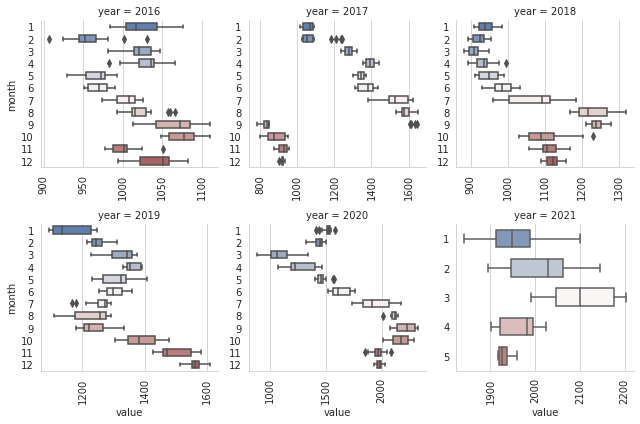

In [ ]:
melt = pd.melt(nse, id_vars=['year', 'month'], value_vars=['Close Price'])
grid = sns.FacetGrid(melt, col = 'year', col_wrap=3, sharex=False, sharey=False)
grid.map(hboxplot, 'value', 'month')

Features columns at different year

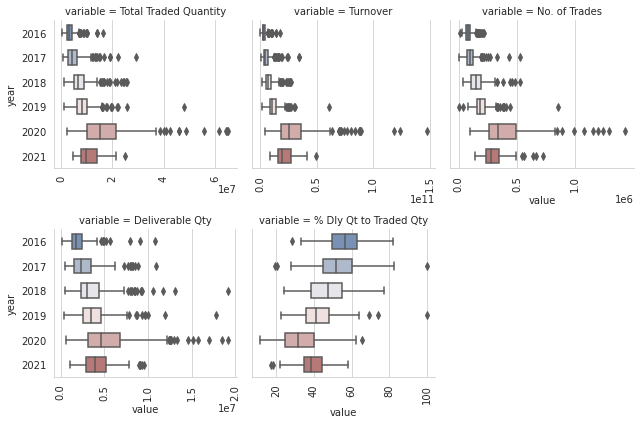

In [ ]:
melt = pd.melt(nse, id_vars=['year'], value_vars=numerical_cols)
grid = sns.FacetGrid(melt, col = 'variable', col_wrap=3, sharex=False)
grid.map(hboxplot, 'value', 'year')

Seasonal Component

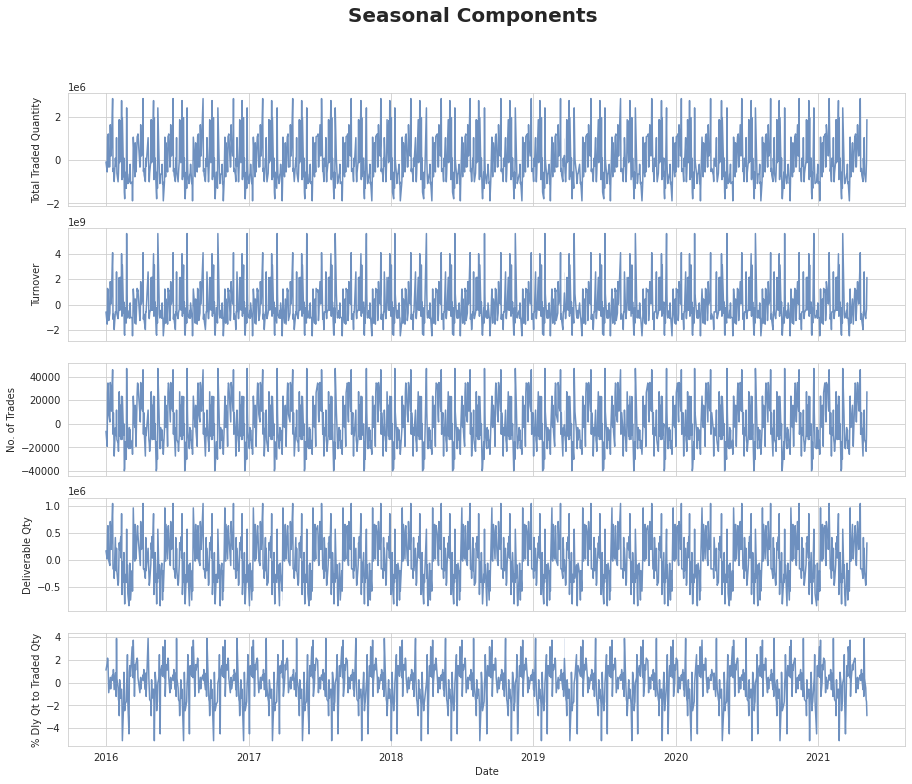

In [ ]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize = (15, 12))
plt.suptitle('Seasonal Components', fontsize = 20, fontweight = 'bold')
for i, col in enumerate(numerical_cols[:5]):
  sns.lineplot(data = nse, x = 'Date', y = f'{col} Seasonal', ax = ax[i])
  ax[i].set_ylabel(col)

#### 4.2 Correlation Pairplot

In [ ]:
def kernel_density(x = 'Close Price', cut_col = 'No. of Trades', nbins = 6, pal = "ch:rot=-.25,hue=1,light=.75"):
  data = nse[[x]].assign(cut = pd.cut(nse[cut_col].values, bins=nbins, include_lowest=True))
  sns.displot(
      data=data,
      x=x, hue="cut",
      kind="kde", height=6,
      multiple="fill", clip=(0, None),
      palette=pal
  )
  plt.title(f'{x} Kernel Density by {cut_col}')

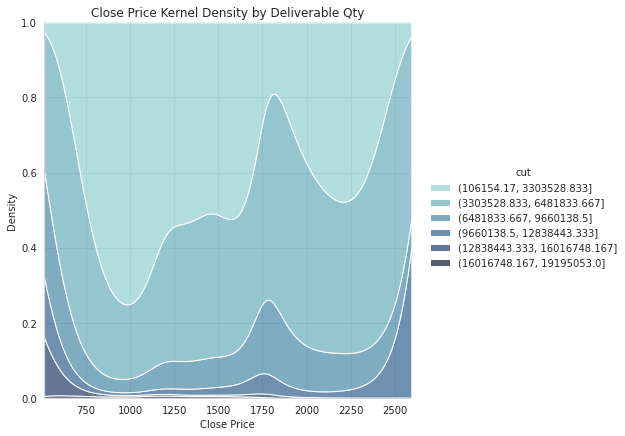

In [ ]:
kernel_density('Close Price', 'Deliverable Qty')

In [ ]:
def scatter_rug(data, x = 'No. of Trades', y = "Close Price", size = "Close Price"):
  g = sns.JointGrid(data=nse, x=x, y=y, space=0, ratio=17)
  g.plot_joint(sns.scatterplot, size=nse[size], sizes=(30, 120),
            alpha=.6, legend=False)
  g.plot_marginals(sns.rugplot, height=1, alpha=.6)

In [ ]:
numerical_cols

Index(['Total Traded Quantity', 'Turnover', 'No. of Trades', 'Deliverable Qty',
       '% Dly Qt to Traded Qty'],
      dtype='object')

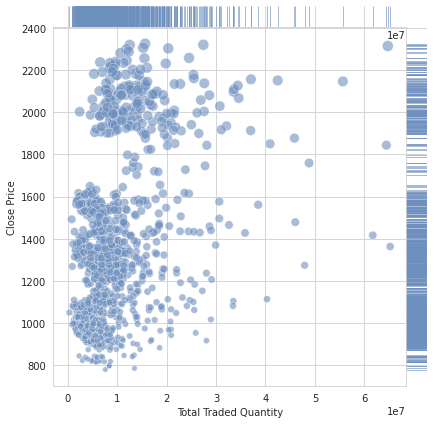

In [ ]:
scatter_rug(nse, 'Total Traded Quantity', "Close Price")

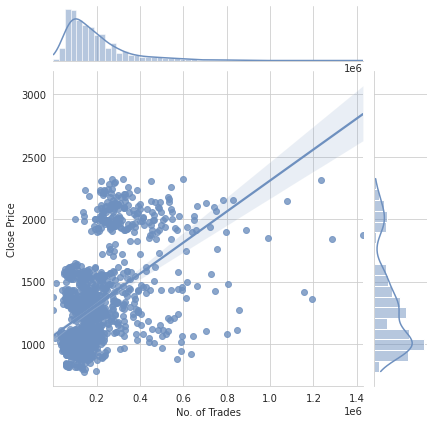

In [ ]:
sns.jointplot(x="No. of Trades", y="Close Price", data=nse, kind="reg")

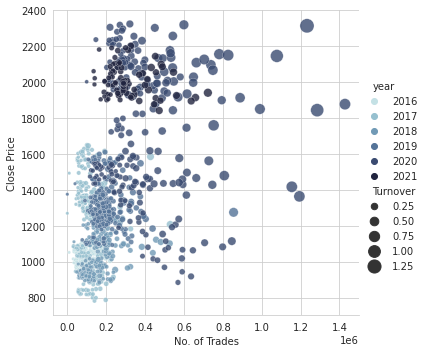

In [ ]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
sns.relplot(x="No. of Trades", y="Close Price", hue="year", size="Turnover",
            sizes=(10, 200), alpha=.8, palette=cmap, data=nse)

Correlation Matrix

In [ ]:
def corr_matrix(df, title = 'Correlation Matrix'):
  corr_matrix = df.corr()
  mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
  cmap = sns.diverging_palette(230, 20, as_cmap=True)

  fig = sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, annot = True)
  fig.set_xticklabels(fig.get_xticklabels(), rotation=80)
  plt.title(title, fontsize=16)

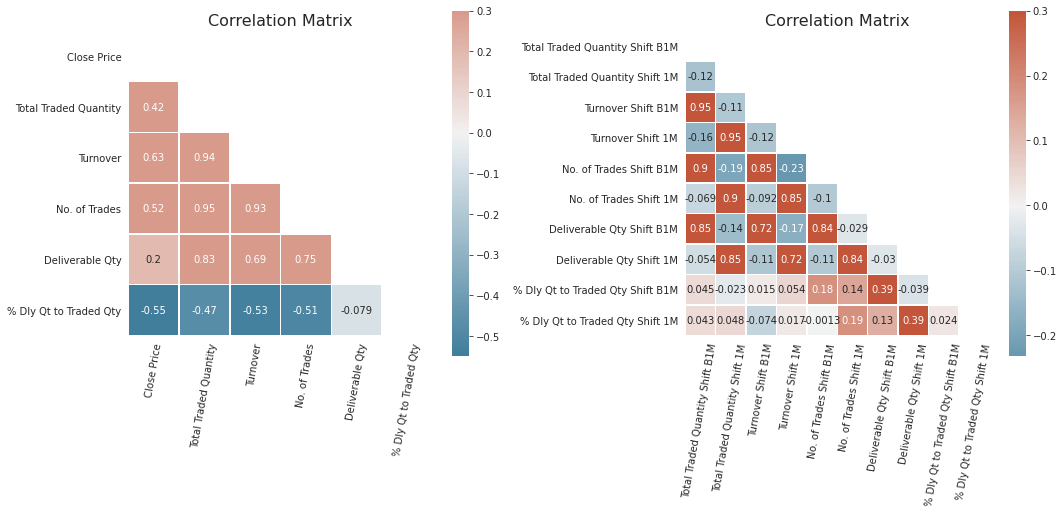

In [ ]:
plt.subplot(1, 2, 1)
corr_matrix(nse[np.append(target_col, numerical_cols)])

plt.subplot(1, 2, 2)
corr_matrix(shifted)
plt.tight_layout()

#### 4.3 Autocorrelation Analysis
> Autocorrelation plots help in detecting seasonality

In [ ]:
from pandas.plotting import autocorrelation_plot

Text(0.5, 1.0, 'Autocorrelation Plot')

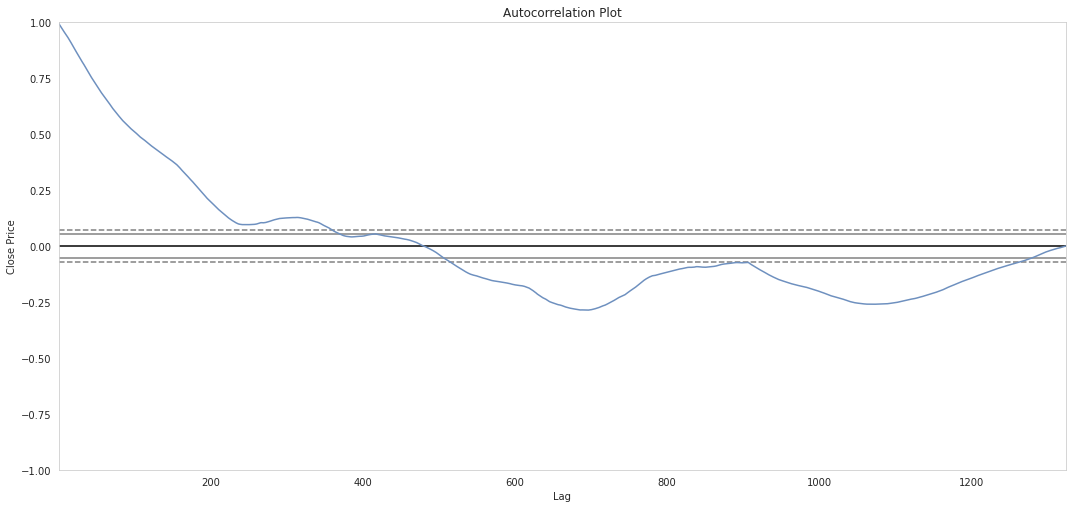

In [ ]:
autocorrelation_plot(nse[target_col])
plt.ylabel(target_col)
plt.tight_layout()
plt.title('Autocorrelation Plot')

- **Autocorrelation Function (ACF):** 
define how observation in time-series related on average and use previous period to forecast the series.
-**Partial Autocorrelation Function (PACF):** 
summary of the relationship between an observation in a time series with observations at prior time steps where effect of correlations due to the terms at shorter lags is removed


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

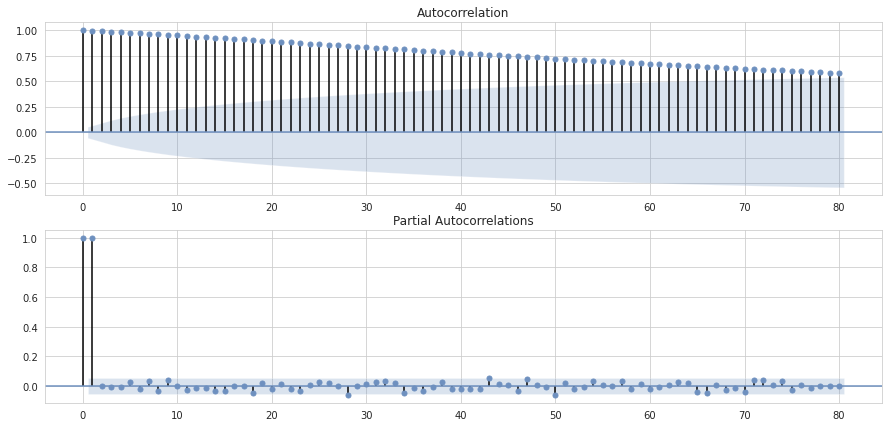

In [ ]:
fig, ax = plt.subplots(2)
plot_acf(nse[target_col], ax = ax[0], lags = 80);
plot_pacf(nse[target_col], title = 'Partial Autocorrelations', ax = ax[1], lags = 80);

- If the autocorrelations are positive for many lags, then the series needs further **differencing**

- On the other hand, if the first lag  of autocorrelation is too negative, then the series is probably **over-differenced**

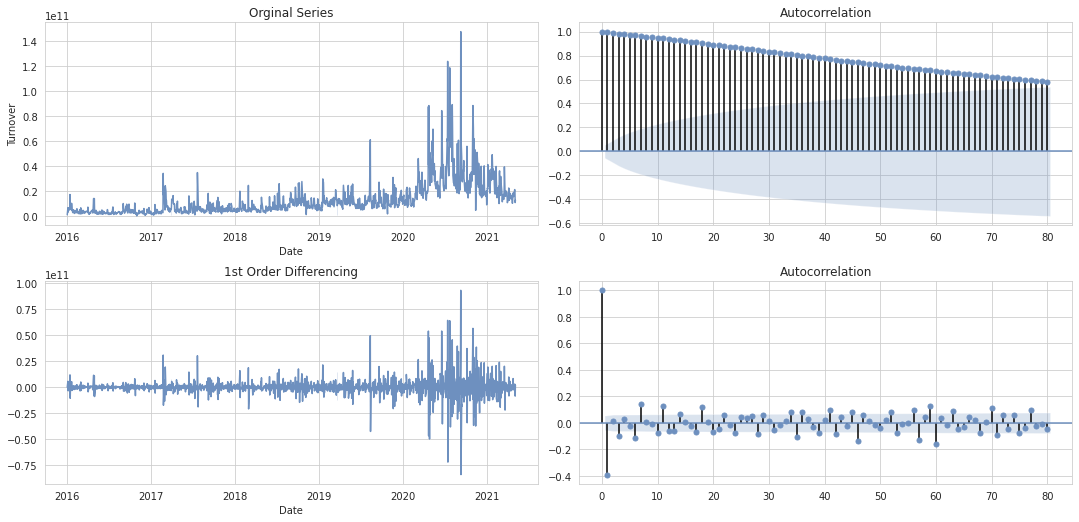

In [ ]:
fig, ax = plt.subplots(2, 2)
plt.tight_layout(h_pad = 3.5)
sns.lineplot(x=nse.Date, y=nse.Turnover, ax=ax[0, 0])
ax[0, 0].set_title('Orginal Series')
plot_acf(nse[target_col], ax = ax[0, 1], lags = 80);
sns.lineplot(x=nse.Date, y=feature_diff, ax=ax[1, 0])
ax[1, 0].set_title('1st Order Differencing')
plot_acf(feature_diff, ax = ax[1, 1], lags = 80);

##  5. Model

Time series can be either univariate or multivariate:

- **Univariate** time series only has a single time-dependent variable.
- **Multivariate** time series have a multiple time-dependent variable.

Cross-validation Technique on Time Series

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
n_split = 2
tfold = TimeSeriesSplit(n_splits=n_split)

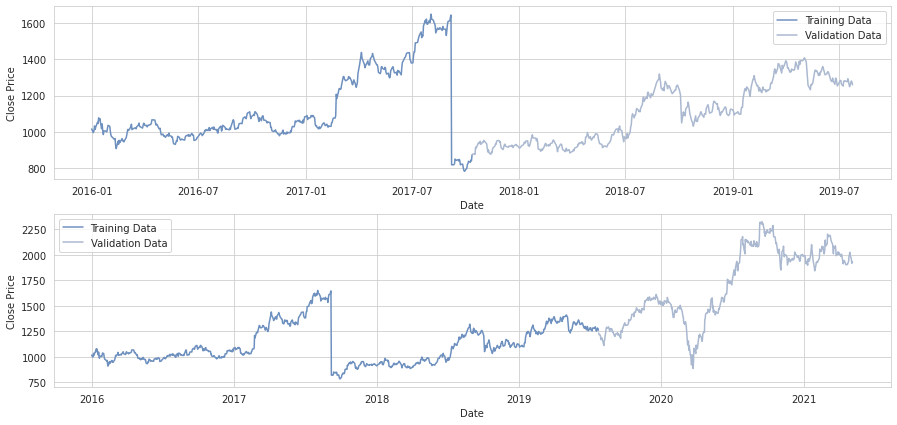

In [ ]:
X = nse.Date
y = nse[target_col]

for i, (train_idx, val_idx) in enumerate(tfold.split(X)):
  X_train, y_train = X[train_idx], y[train_idx]
  X_val, y_val = X[val_idx], y[val_idx]


  plt.subplot(n_split, 1, i+1)
  sns.lineplot(x = X_train, y = y_train, label = 'Training Data')
  sns.lineplot(x = X_val, y = y_val, label = 'Validation Data')

 Metric to measure performance

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [ ]:
def cal_metric(y_real, y_pred):
  rmse = np.sqrt(mean_squared_error(y_real, y_pred))
  mae = mean_absolute_error(y_real, y_pred)
  return rmse, mae

### 5.1 Models for Univariate Time Series


> Only one variable is use over time



Split the data

In [ ]:
train_size = int(len(nse) * 0.85)
cols = ['Date', 'Close Price']
features_col = ['Date']
target_col = ['Close Price']

dataset = nse[cols]
X_train, y_train = nse[features_col][0:train_size].copy(), nse[target_col][0:train_size].copy()
X_val, y_val = nse[features_col][train_size:].copy(), nse[target_col][train_size:].copy()

In [ ]:
train_size, X_train.shape, y_train.shape, X_val.shape, y_val.shape

(1125, (1125, 1), (1125, 1), (199, 1), (199, 1))

#### 5.1.1 fbprophet

In [ ]:
from fbprophet import Prophet

In [ ]:
train_dataset = X_train.assign(y = y_train)
train_dataset.columns = ['ds', 'y']
X_val.columns = ['ds']

**Adding Holidays**


> Adding holidays to the model might increase the model performance

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as holiday_calendars

In [ ]:
cal = holiday_calendars()

train_holidays = cal.holidays(start=train_dataset.ds.min(),
                              end=train_dataset.ds.max())
val_holidays = cal.holidays(start=X_val.ds.min(),
                             end=X_val.ds.max())

In [ ]:
holidays = pd.DataFrame({'ds': np.append(train_holidays, val_holidays), 
                         'holiday': 'USFederalHoliday'})

In [ ]:
model = Prophet(holidays=holidays, holidays_prior_scale=8)
model.add_country_holidays(country_name='India')
model.fit(train_dataset)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


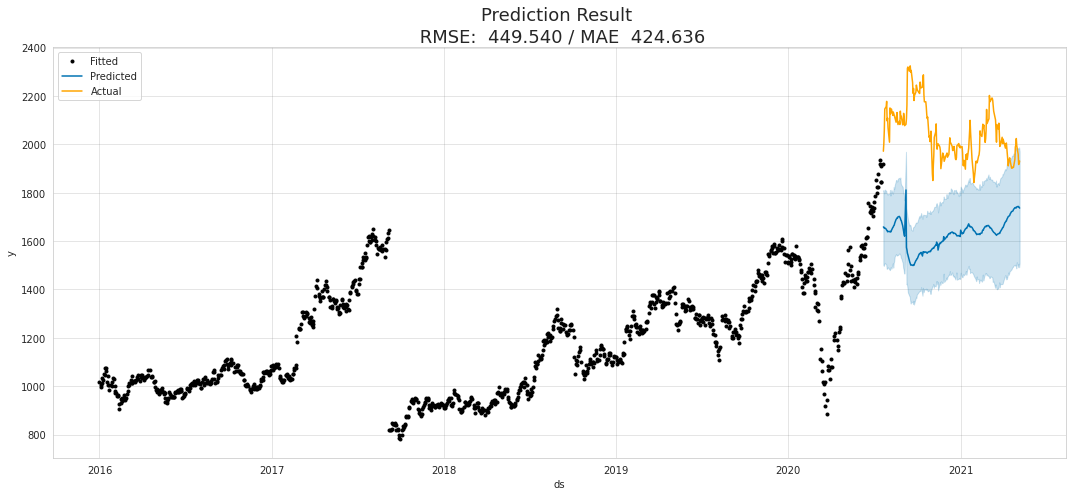

In [ ]:
X_val.columns = ['ds']
pred = model.predict(X_val)
f, ax = plt.subplots(1)

rmse, mae = cal_metric(y_val, pred.yhat)
ax.set_title(f'Prediction Result \n RMSE: {rmse: .3f} / MAE {mae: .3f}', fontsize = 18)
ax.set_xlabel('Date')
ax.set_ylabel('Prediction')
model.plot(pred, ax = ax)
sns.lineplot(x = X_val.ds, y = y_val[target_col[0]], ax = ax, color = 'orange')
plt.legend(['Fitted', 'Predicted', 'Actual']);

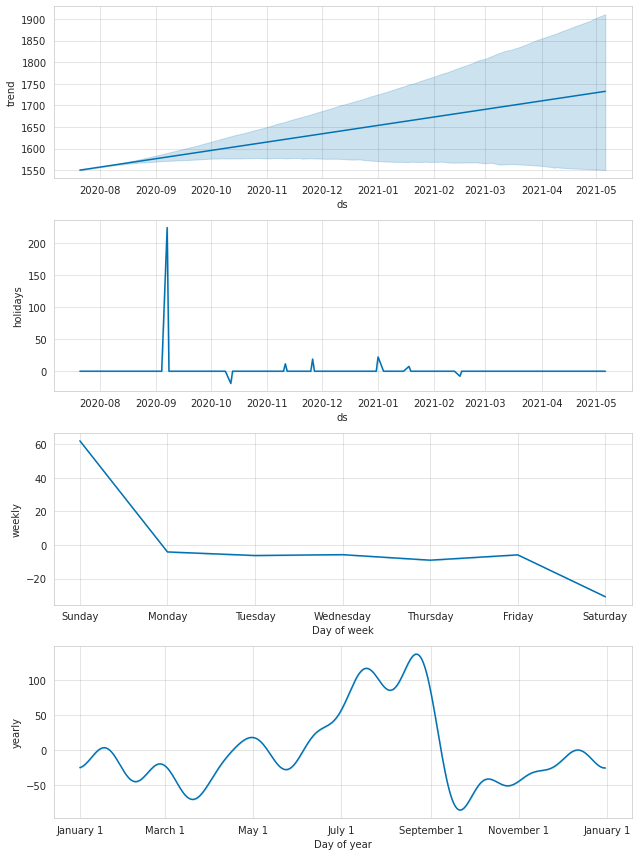

In [ ]:
model.plot_components(pred);

#### 5.1.2 Arima




**ARIMA Model Fomula:**
> Predicted Yt = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)

**d - p - q in ARIMA Model**

1. Find the order of differencing (d)
  - differencing aim for stationary of time series.
  - check for stationarity with Augmented Dickey Fuller test 

2. Find the order of the AR term (p)
  - using Partial Autocorrelation (PACF) plot
  - stationarized series an be rectified by adding AR terms
  - determine number of AR term by observing lags that crosses the significance limit

3. Find order of MA term (q)
  - using Autocorrelation (ACF) plot
  - the error of lagged forecast
  - determine no. of MA terms required


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
ARIMA_order = (1, 1, 1)
model = ARIMA(y_train, order=ARIMA_order)
fitted_model = model.fit()

In [ ]:
fitted_model.forecast()

1125    1920.033084
dtype: float64

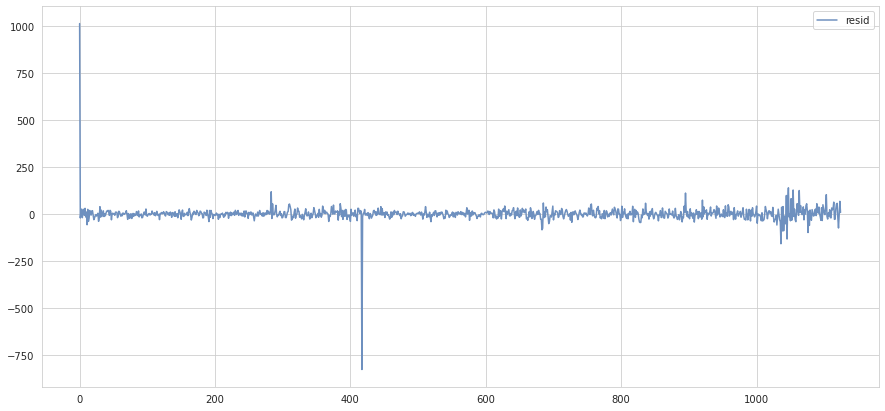

In [ ]:
residuals = pd.DataFrame(fitted_model.resid, columns=['resid'])
residuals.plot()

#### 5.1.3 Auto-Regressive Integrated Moving Average (ARIMA)

In [ ]:
!pip install pmdarima --quiet

In [ ]:
import pmdarima as pm

In [ ]:
model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',     
                      max_p=3, max_q=3,
                      m=1,         
                      d=None,       
                      seasonal=False,
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11099.524, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11095.809, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11097.602, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11097.607, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11094.453, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.629 seconds


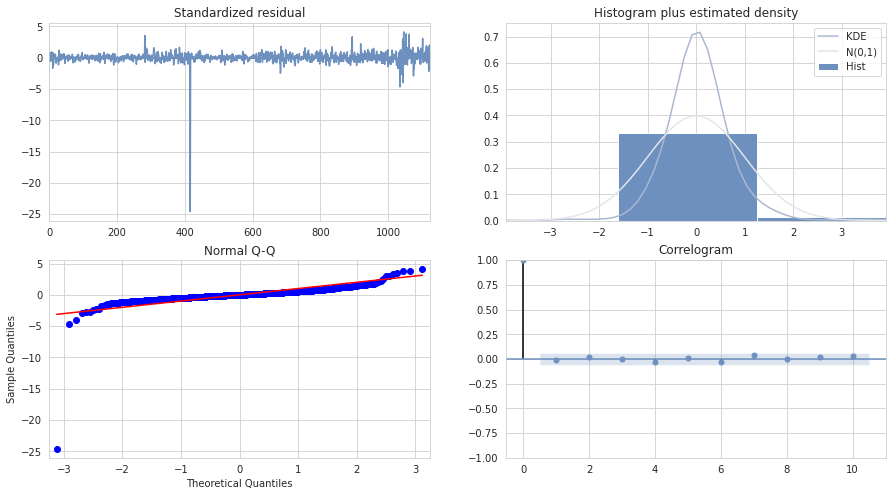

In [ ]:
model.plot_diagnostics(figsize = (15, 8));

#### 5.1.4 LSTM - Long Short Term Memory


> multi-layered LSTM Recurrent Neural Network




Normalize the features

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
target = nse[target_col[0]].values.reshape(-1, 1)
features = nse[features_col[0]].values

In [ ]:
scaler = MinMaxScaler()
target = scaler.fit_transform(target)


Create dataset where `timestep` is use to split the data into feature and target


In [ ]:
def create_dataset(data, timestep=1):
  X, y = [], []
  for i in range(timestep, len(data)):
    feature = data[i - timestep:i]
    X.append(feature)
    targ = data[i]
    y.append(targ)
  return np.array(X), np.array(y)

 Reshape input to be 3D (n_samples, n_timesteps, n_features)

In [ ]:
timestep = 100
train_size = int(0.85 * (len(nse)))
train_size -= timestep
train, test = target[:train_size], target[train_size:]
X_train, y_train = create_dataset(train, timestep)
X_test, y_test = create_dataset(test, timestep)

X_train = np.reshape(X_train, (-1, timestep, 1))
X_test = np.reshape(X_test, (-1, timestep, 1))

X_train.shape, y_train.shape

((925, 100, 1), (925, 1))

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import MeanSquaredError

In [ ]:
model = keras.Sequential([
                          layers.LSTM(128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])),
                          layers.Dropout(0.2),
                          layers.LSTM(50, return_sequences=True),
                          layers.Dropout(0.2),
                          layers.LSTM(50, return_sequences=False),
                          layers.Dense(64),
                          layers.Dense(1)
])

In [ ]:
lr = 1e-4
loss = MeanSquaredError()
metric = ['mae']
optimizer = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss=loss, metrics=metric)

In [ ]:
epochs = 12
batch_size = 1

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/12
925/925 [==============================] - 56s 57ms/step - loss: 0.0059 - mae: 0.0492 - val_loss: 0.0101 - val_mae: 0.0857
Epoch 2/12
925/925 [==============================] - 52s 56ms/step - loss: 0.0034 - mae: 0.0366 - val_loss: 0.0037 - val_mae: 0.0457
Epoch 3/12
925/925 [==============================] - 52s 57ms/step - loss: 0.0026 - mae: 0.0317 - val_loss: 0.0207 - val_mae: 0.1363
Epoch 4/12
925/925 [==============================] - 52s 56ms/step - loss: 0.0024 - mae: 0.0297 - val_loss: 0.0129 - val_mae: 0.1043
Epoch 5/12
925/925 [==============================] - 52s 56ms/step - loss: 0.0024 - mae: 0.0292 - val_loss: 0.0052 - val_mae: 0.0594
Epoch 6/12
925/925 [==============================] - 52s 57ms/step - loss: 0.0021 - mae: 0.0286 - val_loss: 0.0038 - val_mae: 0.0490
Epoch 7/12
925/925 [==============================] - 52s 56ms/step - loss: 0.0020 - mae: 0.0263 - val_loss: 0.0062 - val_mae: 0.0682
Epoch 8/12
925/925 [==============================] - 53s 57ms

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 128)          66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           35800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                3264      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
def visualize_performance(history, metric):
  plt.title(f'Model {metric}')
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+ metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(['train_' + metric, 'val_' + metric])

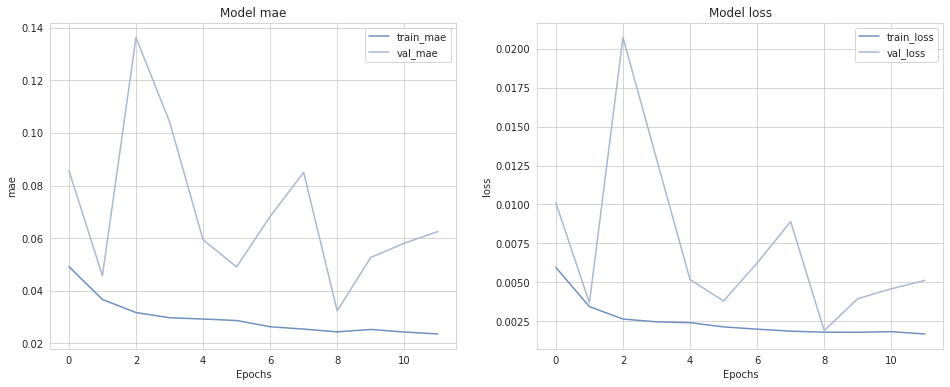

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
visualize_performance(history, 'mae')

plt.subplot(1, 2, 2)
visualize_performance(history, 'loss')

Prediction Result

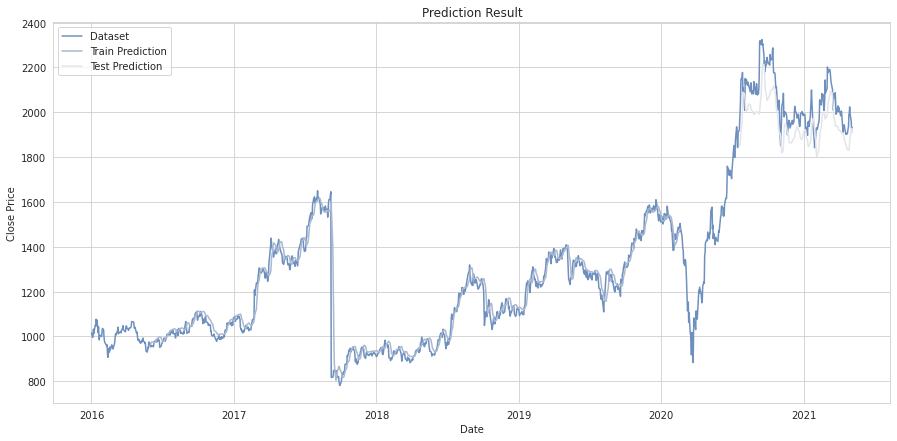

In [ ]:
train_pred = scaler.inverse_transform(model.predict(X_train))
test_pred = scaler.inverse_transform(model.predict(X_test))

train_result = np.empty_like(target) * np.nan
test_result = np.empty_like(target) * np.nan

train_result[timestep:len(train_pred)+timestep, :] = train_pred
test_result[len(train_pred)+(timestep*2):, :] = test_pred

f, ax = plt.subplots(1)
ax.set_title('Prediction Result')
sns.lineplot(x = dataset.Date, y = dataset[target_col[0]], label = 'Dataset', ax = ax)
sns.lineplot(x = dataset.Date, y = train_result[:, 0], label = 'Train Prediction', ax = ax)
sns.lineplot(x = dataset.Date, y = test_result[:, 0], label = 'Test Prediction', ax = ax)

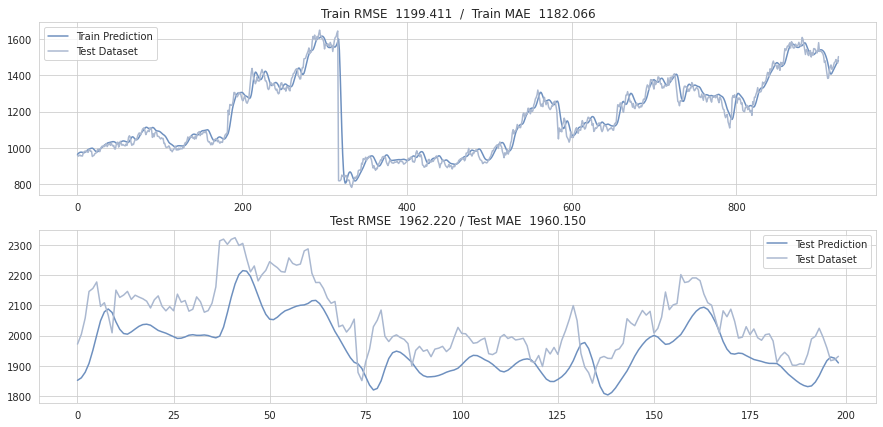

In [ ]:
fig, ax = plt.subplots(2, 1)

rmse, mae = cal_metric(y_train, train_pred)
ax[0].set_title(f'Train RMSE {rmse: .3f}  /  Train MAE {mae: .3f}')
ax[0].plot(train_pred, label = 'Train Prediction')
ax[0].plot(scaler.inverse_transform(y_train), label = 'Test Dataset')
ax[0].legend()

rmse, mae = cal_metric(y_test, test_pred)
ax[1].set_title(f'Test RMSE {rmse: .3f} / Test MAE {mae: .3f}')
ax[1].plot(test_pred, label = 'Test Prediction')
ax[1].plot(scaler.inverse_transform(y_test), label = 'Test Dataset')
ax[1].legend()



Forecasting the future result by adding new prediction as input

In [ ]:
last_100 = target[-100:]

timestep = 100
preds = []
days = 120

for _ in range(days):
  last_100 = last_100[-100:]
  x_input = last_100.reshape(-1, timestep, 1)

  y = model.predict(x_input)
  last_100 = np.append(last_100, y)
  preds.extend(y.tolist())

In [ ]:
preds = scaler.inverse_transform(preds)
start = nse.Date.max() + pd.Timedelta('1D')
forecast_date = pd.date_range(start, periods = days)

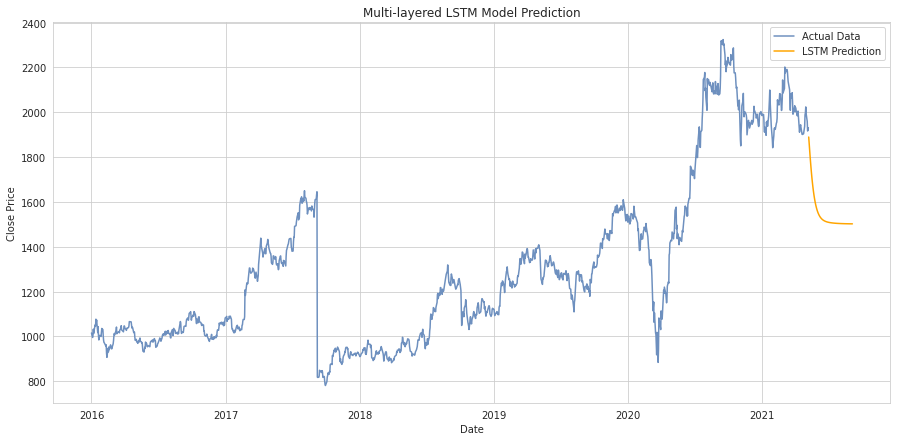

In [ ]:
plt.title('Multi-layered LSTM Model Prediction')
sns.lineplot(x=nse.Date, y=nse[target_col[0]], label='Actual Data')
sns.lineplot(x=forecast_date, y = preds[:, 0], label = 'LSTM Prediction', color='orange')

### 5.2 Models for Multivariate Time Series


> **Multivariate time series:** Multiple variables are useed over time



Data Splitting

#### 5.2.1 fbprophet

  Using multiple features columns to forecast one target

In [ ]:
from fbprophet import Prophet

In [ ]:
train_size = int(0.85 * len(nse))

date = ['Date']
feature_cols = numerical_cols.to_list()
target_col = ['Close Price']
cols = date + feature_cols
dataset = nse[cols + target_col]

train_dataset = dataset.iloc[:train_size]
train_dataset.columns = ['ds'] + feature_cols + ['y']

X_val, y_val = dataset[cols].iloc[train_size:], dataset[target_col].iloc[train_size:]
X_val.columns = ['ds'] + feature_cols

train_size, X_train.shape, y_train.shape, X_val.shape, y_val.shape

(1125, (925, 100, 1), (925, 1), (199, 6), (199, 1))

In [ ]:
model = Prophet()

for col in feature_cols:
  model.add_regressor(col)

model.fit(train_dataset)
pred = model.predict(X_val)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Validation RMSE  247.873 / Validation MAE  205.891')

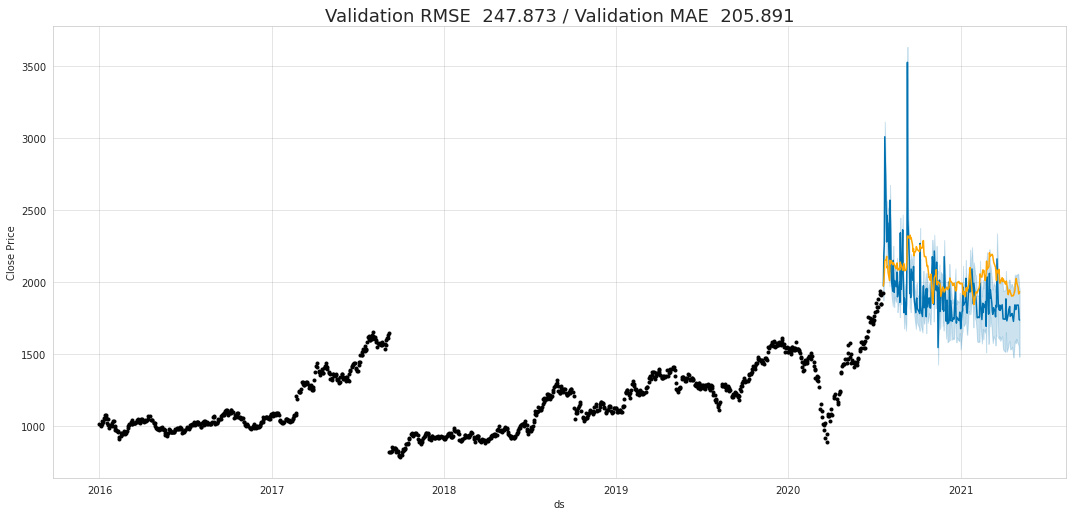

In [ ]:
fig, ax = plt.subplots()
model.plot(pred, ax = ax);
sns.lineplot(x=X_val.ds, y=y_val[target_col[0]], color='orange')
ax.set_ylabel('Close Price')
rmse, mae = cal_metric(y_val, pred.yhat)
ax.set_title(f'Validation RMSE {rmse: .3f} / Validation MAE {mae: .3f}', fontsize = 18)

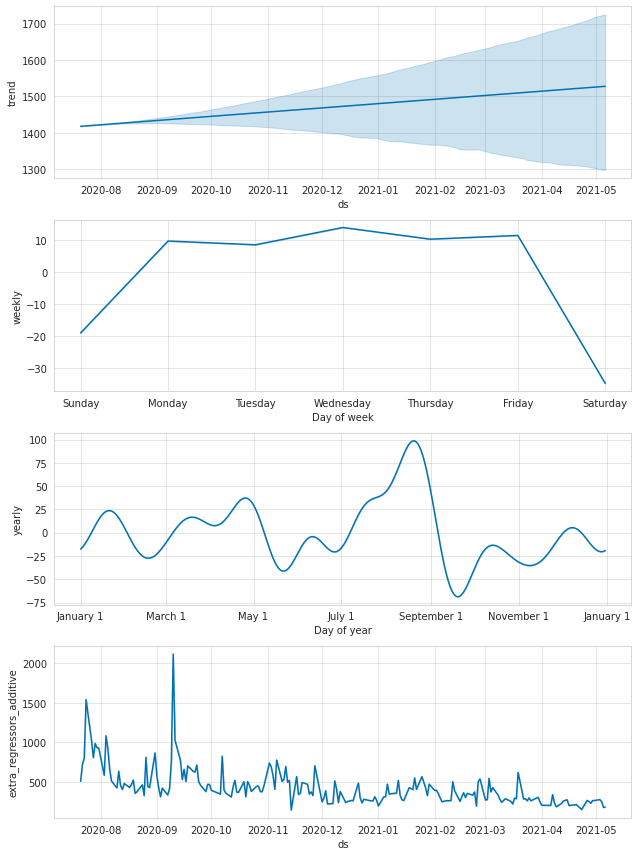

In [ ]:
model.plot_components(pred);

#### 5.2.2 Vector Auto Regression (VAR)


> Using VAR model to predict multiple targets within time series


- **Recursive VAR models:** contain all the components, allow some variable to be function of other
- **Structural VAR models**: identify relationship beyong recursive model, use to forecast impact of indvidual shocks

In [ ]:
date_col = ['Date']
targets_col = numerical_cols.to_list() + ['Close Price']

train_size = int(len(nse) * 0.85)
dataset = nse[date_col + targets_col]
dataset.set_index('Date', inplace=True)

train_dataset = dataset[0:train_size].copy()
val_dataset = dataset[train_size:].copy()


Number of endogenous variables:
- Additional variables:
  - Increase coef to be estimated and number of lags
  - Additional estimation error
- Additional tools to test relevance of variables:
  - **Granger causality:** Granger-causality statistics are F-statistics to test if a variable is significant to predict another variable
  - **Cointegration Test:** establish the presence of a statistically significant connection between two or more time series
  
  

In [ ]:
from statsmodels.tsa.api import VAR

In [ ]:
model = VAR(train_dataset)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Number of Lags (p) can be computed using criteria like Akaike (AIC, Schwarz-Bayesian (BIC), Hannan-Quinn (HQ).

> optimal (p) will give the lowest ‘AIC’, ‘BIC’, ‘FPE’ and ‘HQIC’ scores




In [ ]:
model.select_order(maxlags = 8).summary()

,AIC,BIC,FPE,HQIC
0,137.9,137.9,7.786e+59,137.9
1,131.9,132.1,1.928e+57,132.0
2,131.5,131.9*,1.341e+57,131.7*
3,131.5,132.0,1.300e+57,131.7
4,131.5*,132.2,1.281e+57*,131.7
5,131.5,132.3,1.293e+57,131.8
6,131.5,132.5,1.305e+57,131.9
7,131.5,132.7,1.299e+57,131.9
8,131.5,132.8,1.315e+57,132.0


In [ ]:
fitted_model = model.fit(maxlags = 4)
fitted_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 21, Aug, 2021
Time:                     14:45:06
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    132.153
Nobs:                     1121.00    HQIC:                   131.735
Log likelihood:          -83089.0    FPE:                1.26359e+57
AIC:                      131.481    Det(Omega_mle):     1.10696e+57
--------------------------------------------------------------------
Results for equation Total Traded Quantity
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                       5365098.367904   2184977.084138            2.455           0.014
L1.Total Traded Quantity         -0.399642         0.225054           -1.776           0.

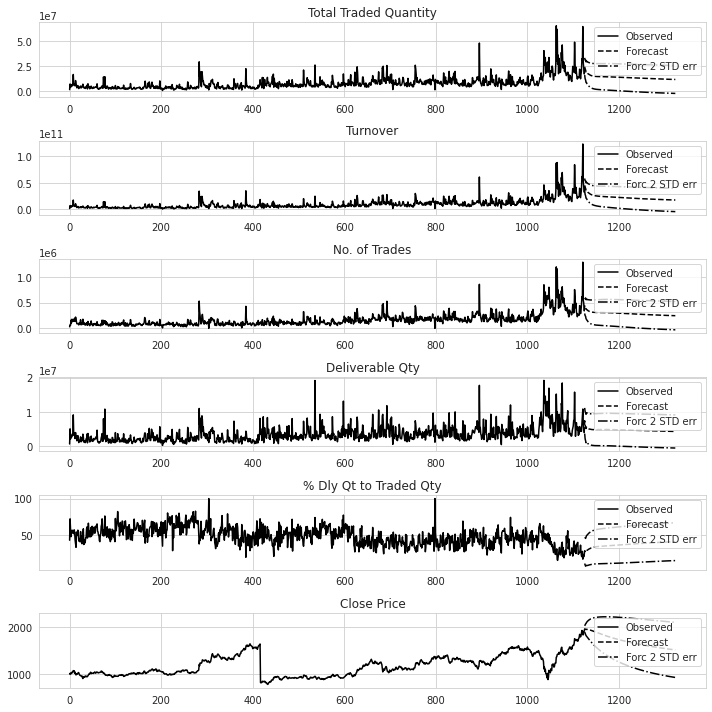

In [ ]:
fitted_model.plot_forecast(len(X_val));
plt.tight_layout()

To forecast with VAR model, we have to provide at least (p) number of lags

In [ ]:
fitted_model.k_ar

4

In [ ]:
prediction = fitted_model.forecast(y = train_dataset.values, steps = len(X_val))
prediction = pd.DataFrame(prediction, columns=targets_col, index=X_val.index)

Evaluate VAR models
- Granger-causality statistics.
- Impulse response functions.
- Forecast error decompositions

In [ ]:
plt.plot(prediction[target])

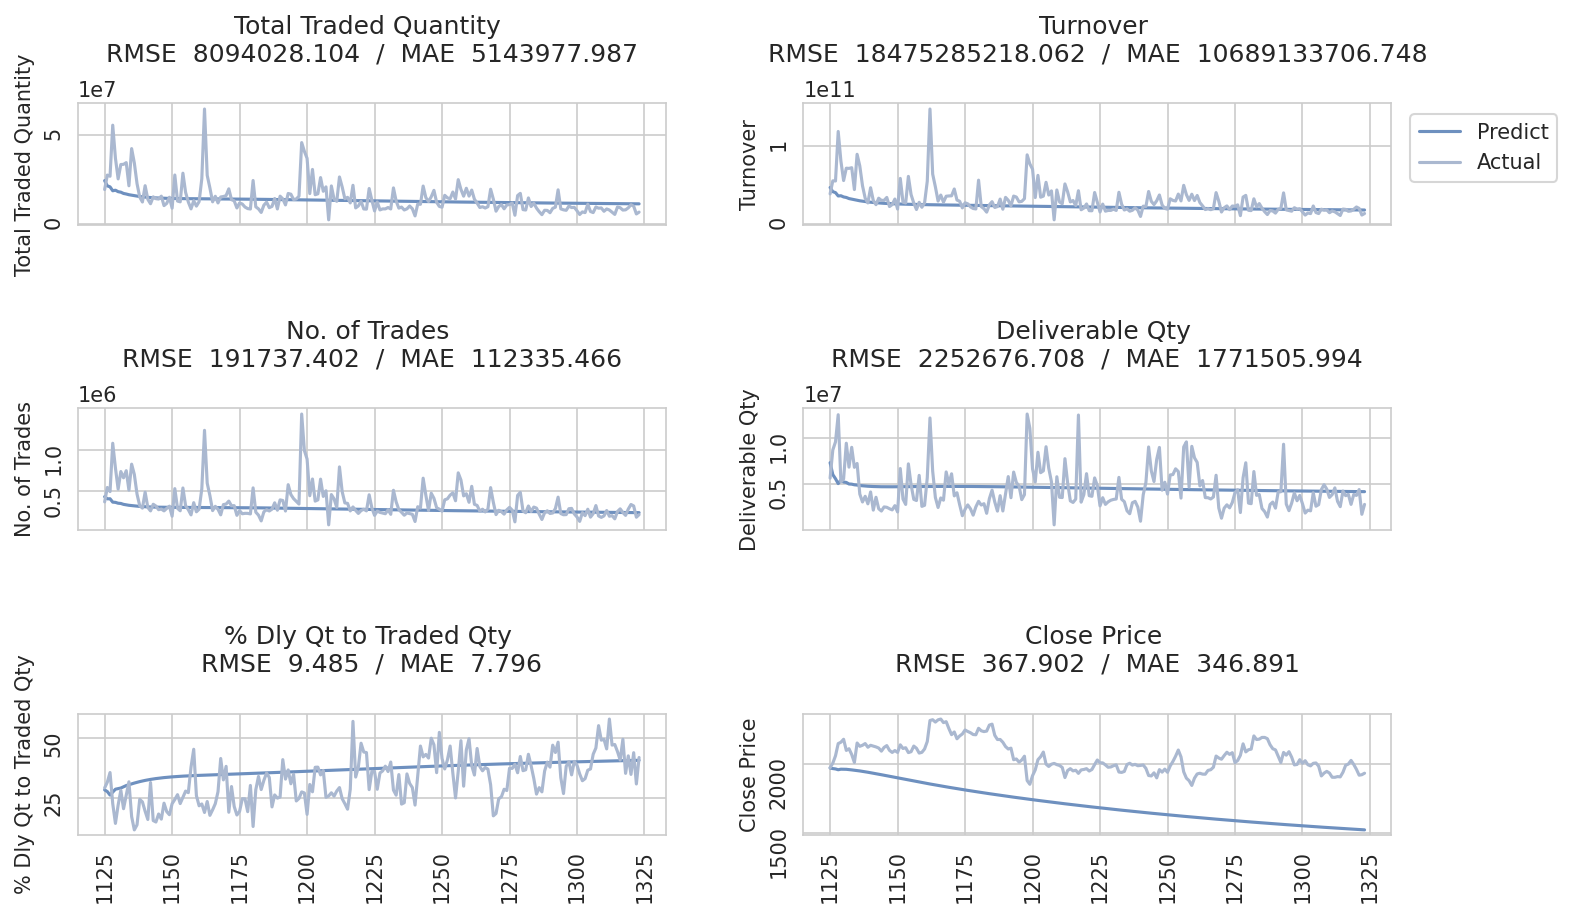

In [ ]:
fig, axes = plt.subplots(int(len(targets_col)/2), 2, dpi=150, figsize=(10, 6), sharex=True)

for i, (target, ax) in enumerate(zip(targets_col, axes.flatten())):
  rmse, mae = cal_metric(val_dataset[target].values, prediction[target].values)

  sns.lineplot(x=prediction.index, y=prediction[target], ax=ax)
  sns.lineplot(x=prediction.index, y=val_dataset[target], ax=ax)
  ax.set_title(f'{target} \nRMSE {rmse: .3f}  /  MAE {mae: .3f}', pad=20)
  
plt.tight_layout(h_pad=4, w_pad=2)
plt.legend(['Predict', 'Actual'], bbox_to_anchor=(1.3, 6), loc='upper right')
t = [ax.tick_params(labelrotation=90) for ax in fig.axes]

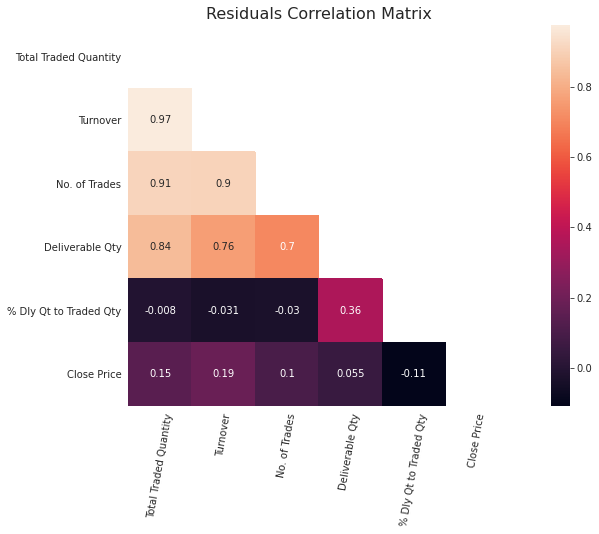

In [ ]:
corr_matrix = fitted_model.resid_corr
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
fig = sns.heatmap(corr_matrix, mask=mask, square=True, annot=True, yticklabels=targets_col)
fig.set_xticklabels(targets_col, rotation=80)
plt.title('Residuals Correlation Matrix', fontsize=16);

### References:

In [ ]:
# https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
# https://www.sciencedirect.com/topics/chemistry/autocorrelation-function
# https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
# https://www.kaggle.com/andreshg/timeseries-analysis-a-complete-guide
# https://www.aptech.com/blog/introduction-to-the-fundamentals-of-vector-autoregressive-models/
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
# https://www.kaggle.com/robikscube/time-series-forecasting-with-prophet#Look-at-first-month-of-predictions